# 1D CTF

In [1]:
%matplotlib inline
import numpy as np
np.seterr(divide='ignore', invalid='ignore')  # disable divide by zero warnings
import matplotlib.pyplot as plt
from ipywidgets import widgets  # interactive slider

In [2]:
ONE_METER = 1
ONE_MILLIMETER = ONE_METER*1e-3
ONE_NANOMETER = ONE_METER*1e-9
ONE_ANGSTROM = ONE_METER*1e-10

* The wavelength of the electron at 300 keV is 0.001968 nm
* The spherical aberration is 2.62 mm
* Pixel size is 1 A/pix

In [3]:
def electron_wavelength(acc_volt):
    """
    :param acc_volt: acceleration voltage (unit: volt)
    :return: electron wavelength (unit: meters)
    """
    c = 299792458.0  # m/s
    h = 6.626068e-34  # kg*m²/s
    m = 9.10938356e-31  # kg
    e = 1.60217646e-19  # C
    return np.sqrt(h*h * c*c / (e*acc_volt * (2*m*c*c + e*acc_volt)))

In [4]:
def scherzer_defocus(cs, wavelength):
    """
    :param wavelength: wavelength of the electron wave (unit: meter)
    :param cs: spherical aberration of the objective lens (unit: meter)
    :return: scherzer defocus (unit: meter)
    """
    return 1.2 * np.power(cs * wavelength, 0.5)

In [5]:
def chi(u, wavelength, cs, defocus):
    """
    :param u: spacial frequency (unit: 1/nm)
    :param wavelength: wavelength of the electron wave (unit: meter)
    :param cs: spherical aberration of the objective lens (unit: meter)
    :param defocus: positive values means underfocus, negative values mean overfocus (unit: meter)
    :return: wave aberration function
    """
    a = np.pi * wavelength * defocus
    b = 0.5 * np.pi * cs * np.power(wavelength, 3)
    return - a*np.power(u,2) + b*np.power(u,4)

In [6]:
# Microscope parameters
wavelength = electron_wavelength(300e3)
cs = 2.62 * 1e-3  # m
pixel_size = 1 * 1e-10  # m

In [7]:
@widgets.interact(defocus=(-2000,2000,10))
def plot_ctf(defocus=scherzer_defocus(cs, wavelength)*1e9):
    
    # Calculate the CTF
    n_samples = 500
    frequencies = np.fft.fftfreq(n_samples, d=1)
    frequencies = frequencies[:n_samples//2]  # select only positive values
    spatial_freq = frequencies / pixel_size
    defocus = defocus * 1e-9  # convert to meter
    ctf = np.sin(chi(spatial_freq, wavelength, cs, defocus))
    
    # Plot 
    fig, ax = plt.subplots()
    ax.plot(frequencies*2, ctf, label='CTF')
    legend = ax.legend(loc='best', shadow=True)
    plt.xlabel("Fraction of nyquist")

A Jupyter Widget

## Phase plate

#### Constant phase shift

The simples way to model the phase shift is to add a constant phase shift to the spherical aberration function. 

In [8]:
# Microscope parameters
wavelength = electron_wavelength(300e3)
cs = 2.62 * 1e-3  # m
pixel_size = 1 * 1e-10  # m

In [9]:
@widgets.interact(defocus=(-2000,2000,10), phi=(0,2,0.1))
def plot_ctf(defocus=scherzer_defocus(cs, wavelength)*1e9, phi=0):
    
    # CTF with phase shift
    n_samples = 500
    frequencies = np.fft.fftfreq(n_samples, d=1)
    frequencies = frequencies[:n_samples//2]  # select only positive values
    spatial_freq = frequencies / pixel_size
    defocus = defocus * 1e-9  # convert to meter
    phase_shift = phi * np.pi
    ctf = np.sin(chi(spatial_freq, wavelength, cs, defocus) + phase_shift)

    # Plot
    fig, ax = plt.subplots()
    ax.plot(frequencies*2, ctf, label='CTF')
    legend = ax.legend(loc='best', shadow=True)
    plt.xlabel("Fraction of nyquist")

A Jupyter Widget

#### The phase shift is dependent on the spot size [[1](https://elifesciences.org/articles/23006#fig2)]

The Volta phase plate is not an ideal phase plate, so the phase shift added to the frequencies is not constant, but frequency dependent.

"Factors such as specimen charging, specimen thickness and beam drift could cause the central beam to change its shape or move on the phase plate and thus modify the central spot. We approximated the central spot of the VPP with a Gaussian function which has only one parameter - the size of the spot."

In [10]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x-mu, 2.) / (2 * np.power(sig, 2.)))

In [11]:
@widgets.interact(phase_shift=(0,2,0.1), spot_size=(0,0.5,0.01))
def plot_phase_shift(phi=0.5, spot_size=0.05):
    
    # Calculate frequency dependent phase shift
    n_samples = 500
    frequencies = np.fft.fftfreq(n_samples, d=1)
    frequencies = frequencies[:n_samples//2]  # select only positive values
    spatial_freq = frequencies / pixel_size
    spot_size = spot_size * (1/ONE_NANOMETER)
    phase_shift = phi * (1 - gaussian(spatial_freq, mu=0, sig=spot_size))
    
    # Plot
    fig, ax = plt.subplots()
    ax.plot(frequencies*2, phase_shift, label='Phase shift')
    legend = ax.legend(loc='best', shadow=True)
    plt.xlabel("Fraction of nyquist")
    plt.ylabel(r"Phase shift ($\pi$)")
    plt.ylim(-0.1,2)

A Jupyter Widget

In [12]:
@widgets.interact(defocus=(-2000,2000,10), phase_shift=(0,2,0.1), spot_size=(0,0.5,0.01))
def plot_ctf_with_phase_shift(defocus=500, phi=0.5, spot_size=0.05):
    
    # Calculate CTF with phase shift
    n_samples = 500
    frequencies = np.fft.fftfreq(n_samples, d=1)
    frequencies = frequencies[:n_samples//2]  # select only positive values
    spatial_freq = frequencies / pixel_size
    defocus = defocus * 1e-9  # convert to meter
    spot_size = spot_size * (1/ONE_NANOMETER)
    phase_shift = phi * np.pi * (1 - gaussian(spatial_freq, mu=0, sig=spot_size))
    ctf = np.sin(chi(spatial_freq, wavelength, cs, defocus) + phase_shift)
    
    # Plot
    fig, ax = plt.subplots()
    ax.plot(frequencies*2, ctf, label='CTF')
    legend = ax.legend(loc='lower right', shadow=True)
    plt.xlabel("Fraction of nyquist")

A Jupyter Widget

In [13]:
def ctf_with_phase_plate(freq, phi, spot_size, defocus, cs=2.62e-3):
    """
    :param freq: spacial frequency (unit: 1/nm)
    :param phi: phase shift in fraction of pi
    :param spot_size: size of the phase plate spot in reciprocal space (unit: 1/nm)
    :param defocus: positive values means underfocus, negative values mean overfocus (unit: nanometer)
    :return: ctf with frequency dependent phase shift
    """
    ONE_METER = 1
    ONE_NANOMETER = ONE_METER*1e-9
    spot_size = spot_size * (1/ONE_NANOMETER)
    phase_shift = phi * np.pi * (1 - gaussian(freq, mu=0, sig=spot_size))
    ctf = np.sin(chi(freq, wavelength, cs, defocus) + phase_shift)
    return ctf

In [14]:
@widgets.interact(defocus=(-2000,2000,10), phase_shift=(0,2,0.1), spot_size=(0,0.5,0.01))
def plot_ctf_with_phase_shift(defocus=500, phi=0.5, spot_size=0.05):
    
    # Calculate CTF with phase shift
    n_samples = 500
    frequencies = np.fft.fftfreq(n_samples, d=1)
    frequencies = frequencies[:n_samples//2]  # select only positive values
    spatial_freq = frequencies / pixel_size
    defocus = defocus * 1e-9  # convert to meter

    ctf = ctf_with_phase_plate(spatial_freq, phi, spot_size, defocus)
    
    # Plot
    fig, ax = plt.subplots()
    ax.plot(frequencies*2, ctf, label='CTF')
    legend = ax.legend(loc='lower right', shadow=True)
    plt.xlabel("Fraction of nyquist")

A Jupyter Widget

# 2D CTF

#### Basic image parameters

In [15]:
m,n = image_dimensions = (1000,1000)
pixel_size = 1e-10

In [16]:
@widgets.interact(defocus=(-2000,2000,10), phi=(0,2,0.1), spot_size=(0,0.5,0.01))
def plot_2d_ctf(defocus=500, phi=0.5, spot_size=0.05):
    
    # Calculate CTF
    x = np.fft.fftfreq(m, d=1)
    y = np.fft.fftfreq(n, d=1)
    X, Y = np.meshgrid(x, y, indexing='ij')
    freq_2d = np.sqrt(X**2 + Y**2)
    spatial_freq = freq_2d / pixel_size
    defocus = defocus * 1e-9  # convert to meter
    ctf = ctf_with_phase_plate(spatial_freq, phi, spot_size, defocus)
    
    # Plot
    plt.figure(figsize=(8,5))
    plt.imshow(np.fft.fftshift(ctf), cmap = 'gray')

A Jupyter Widget

# CTFy Image 

In [17]:
from scipy import misc
from PIL import Image 

#### Specify the path to the image file

In [18]:
image_file_path = "my_image.png"

#### Open the image as an array and convert it to grayscale

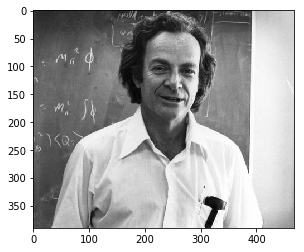

In [23]:
image = Image.open(image_file_path) # open colour image
image_bw = image.convert('L') # convert to greyscale
image_array = np.array(image_bw)
plt.imshow(image_array, cmap='gray')

#### Specify an arbitrary pixel size of the image

In [24]:
pixel_size_image = 3*1e-10

#### Fourier transform the image

In [25]:
ft_image = np.fft.fft2(image_array)

#### Apply defocus and phase shift on an image [[2](http://www.sciencedirect.com/science/article/pii/S0959440X1730043X?via%3Dihub)]

In [26]:
@widgets.interact(defocus=(-2000,2000,10), phase_shift=(0,2,0.1), spot_size=(0,0.5,0.01), continuous_update=False)
def plot_ctfyed_image(defocus=80, phase_shift=0, spot_size=0.05):
    
    m,n = image_array.shape
    x = np.fft.fftfreq(m, d=1)
    y = np.fft.fftfreq(n, d=1)
    X, Y = np.meshgrid(x, y, indexing='ij')
    frequencies = np.sqrt(X**2 + Y**2)
    spatial_freq = frequencies / pixel_size_image
    defocus = defocus * 1e-9  # convert to meter
    
    # Calculate CTF
    ctf = ctf_with_phase_plate(spatial_freq, phase_shift, spot_size, defocus)
    
    # Apply CTF on Image
    ctf_ft_image = ft_image * ctf
    ctf_ft_image[0,0] = ft_image[0,0]  # don't shift the dc component
    ctfyed_image = np.fft.ifft2(ctf_ft_image)
    
    # Plot
    plt.figure(figsize=(16,10))
    plt.subplot(131)
    plt.imshow(image_array, cmap = 'gray')
    plt.subplot(132)
    plt.imshow(ctfyed_image.real, cmap = 'gray')
    plt.subplot(133)
    plt.imshow(np.fft.fftshift(ctf), cmap = 'gray')

A Jupyter Widget